# sarima

In [1]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
INPUT_PATHS = ["cleaned_data_out.csv", "cleaned_data.csv"]  # will use first that exists
DATE_COL_OVERRIDE = None  # e.g., "order_day"  (set to None to auto-detect)
TARGET_COL_OVERRIDE = None  # e.g., "gross_sales"  (set to None to auto-detect)

Loaded: cleaned_data.csv
Using date column:   order_day
Using target column: gross_sales


/var/folders/q7/zjfk4hdx0ss5gnlksy_ljmqr0000gn/T/ipykernel_77900/2571969165.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
/var/folders/q7/zjfk4hdx0ss5gnlksy_ljmqr0000gn/T/ipykernel_77900/2571969165.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
/var/folders/q7/zjfk4hdx0ss5gnlksy_ljmqr0000gn/T/ipykernel_77900/2571969165.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and w

Model: auto_arima -> SARIMA(0, 1, 1)(0, 0, 0, 7)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2739.678
Date:                Wed, 03 Sep 2025   AIC                           5483.355
Time:                        22:53:19   BIC                           5491.139
Sample:                    08-01-2024   HQIC                          5486.450
                         - 07-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5835      0.024    -24.265      0.000      -0.631      -0.536
sigma2      2.209e+05   8700.372     25.391      0.000    2.04e+05    2.38e+05
Lju

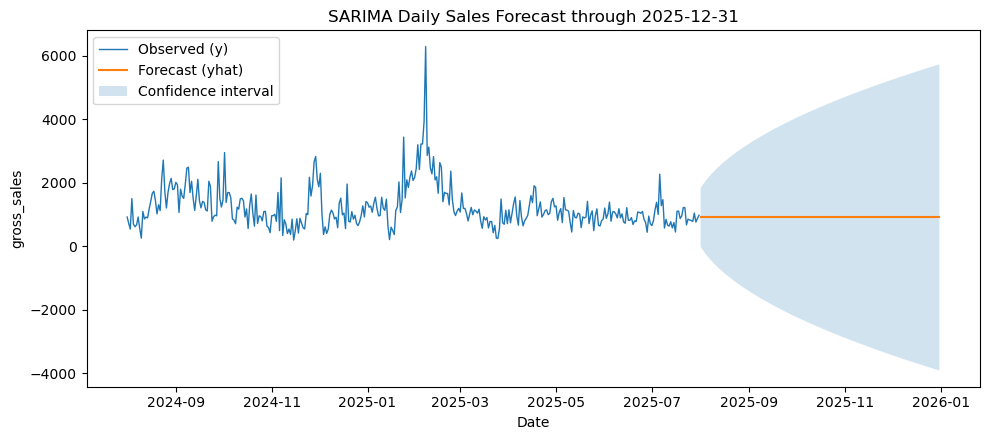

Saved: sarima_model_summary.txt


In [3]:
df_raw = None
for p in INPUT_PATHS:
    if os.path.exists(p):
        try:
            df_raw = pd.read_csv(p)
            print(f"Loaded: {p}")
            break
        except Exception as e:
            print(f"Failed to read {p}: {e}")
assert df_raw is not None, "Couldn't find a cleaned data CSV in INPUT_PATHS."

# Detect date column
def detect_date_col(df):
    candidates = []
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            nonnull = parsed.notna().sum()
            if nonnull >= 0.3*len(df) and parsed.dt.date.nunique() >= 10:
                candidates.append((c, nonnull))
        except Exception:
            pass
    if not candidates:
        return None
    candidates.sort(key=lambda x: (-x[1], x[0]))
    return candidates[0][0]

date_col = DATE_COL_OVERRIDE or detect_date_col(df_raw)
assert date_col is not None, "No date-like column found. Set DATE_COL_OVERRIDE to your datetime column."

df_raw[date_col] = pd.to_datetime(df_raw[date_col], errors="coerce")
df = df_raw.dropna(subset=[date_col]).copy()

# Detect target (sales) column
priority = ["gross_sales","net_sales","total_sales","revenue","sales","orders","qty","quantity","units"]
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

def detect_target_col(df, num_cols, priority):
    for k in priority:
        for c in num_cols:
            if k in c.lower():
                return c
    return max(num_cols, key=lambda c: df[c].var()) if num_cols else None

target_col = TARGET_COL_OVERRIDE or detect_target_col(df, num_cols, priority)
assert target_col is not None, "No numeric target column found. Set TARGET_COL_OVERRIDE to your sales metric."

print(f"Using date column:   {date_col}")
print(f"Using target column: {target_col}")

# Aggregate to DAILY sums
daily = (
    df.groupby(df[date_col].dt.floor("D"))[target_col]
      .sum()
      .to_frame(name="y")
      .sort_index()
)

# Make sure the index is continuous daily (fill missing days with 0)
start = daily.index.min()
last_hist = daily.index.max()
end_2025 = pd.Timestamp("2025-12-31")
full_index = pd.date_range(start, max(last_hist, end_2025), freq="D")
daily = daily.reindex(full_index).fillna(0.0)

# ================================
# Train Model (SARIMA)
# ================================
auto_used = False
order = (1,1,1)
seasonal_order = (1,1,1,7)  # weekly seasonality for daily data, safe default
model_info = "Default SARIMA(1,1,1)(1,1,1,7)"

hist = daily.loc[:last_hist, "y"].copy()

try:
    from pmdarima import auto_arima
    stepwise_fit = auto_arima(hist,
                              seasonal=True, m=7,     # weekly seasonality
                              suppress_warnings=True,
                              error_action="ignore",
                              trace=False)
    order = stepwise_fit.order
    seasonal_order = stepwise_fit.seasonal_order
    auto_used = True
    model_info = f"auto_arima -> SARIMA{order}{seasonal_order}"
except Exception as e:
    print(f"auto_arima not used (reason: {e}). Falling back to {model_info}")

from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima = SARIMAX(hist,
                 order=order,
                 seasonal_order=seasonal_order,
                 enforce_stationarity=False,
                 enforce_invertibility=False)
results = sarima.fit(disp=False)

print("Model:", model_info)
print(results.summary())

# ================================
# Forecast Away (through 2025-12-31)
# ================================
forecast_index = pd.date_range(last_hist + pd.Timedelta(days=1), end_2025, freq="D")
steps = len(forecast_index)
if steps < 1:
    print("History already extends to 2025-12-31. No future days to forecast.")
    forecast_index = pd.DatetimeIndex([])

pred = results.get_forecast(steps=steps)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Prophet-like output
future_df = pd.DataFrame({"ds": forecast_index})
if steps > 0:
    future_df["yhat"] = pred_mean.reindex(forecast_index).values
    if pred_ci is not None and not pred_ci.empty:
        lower_col, upper_col = pred_ci.columns[0], pred_ci.columns[1]
        future_df["yhat_lower"] = pred_ci.reindex(forecast_index)[lower_col].values
        future_df["yhat_upper"] = pred_ci.reindex(forecast_index)[upper_col].values
    else:
        future_df["yhat_lower"] = np.nan
        future_df["yhat_upper"] = np.nan

# ================================
# Save Forecast to CSV + Quick Plots
# ================================
OUT_CSV = "sarima_forecast_2025.csv"
future_df.to_csv(OUT_CSV, index=False)
print(f"Saved: {OUT_CSV}")

# Plot history + forecast
plt.figure(figsize=(10,4.5))
plt.plot(hist.index, hist.values, label="Observed (y)", linewidth=1)
if steps > 0:
    plt.plot(forecast_index, future_df["yhat"], label="Forecast (yhat)", linewidth=1.5)
    if "yhat_lower" in future_df:
        plt.fill_between(forecast_index,
                         future_df["yhat_lower"],
                         future_df["yhat_upper"],
                         alpha=0.2, label="Confidence interval")
plt.title("SARIMA Daily Sales Forecast through 2025-12-31")
plt.xlabel("Date"); plt.ylabel(target_col)
plt.legend(); plt.tight_layout(); plt.show()

# Optional: export model summary text
with open("sarima_model_summary.txt", "w") as f:
    f.write(f"Date column: {date_col}\nTarget column: {target_col}\nAuto-ARIMA used: {auto_used}\nModel: {model_info}\n\n")
    f.write(results.summary().as_text())
print("Saved: sarima_model_summary.txt")